# Objetivo

Avaliar se há clusters no portfólio 1. Em um segundo momento, a partir de uma clusterização global (na base toda), buscar novos clientes na base completa.

# Método

A partir do conjunto reduzido de features (47), aplicar um processo de clusterização (AgglomerativeClustering).

# Leitura dos arquivos

In [5]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import feather

## Leitura da lista de features a excluir

In [35]:
# obtida em EDA Pandas_profiling_sample_10k_market.ipynb
exclude_df = pd.read_csv('exclude_variables_generated_from_profiling.csv')
exclude_variables = exclude_df.values.squeeze().tolist()
len(exclude_variables)

## Carregamento Portfólio 1

In [120]:
p1 = pd.read_csv('estaticos_portfolio1.csv')
p1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Columns: 182 entries, Unnamed: 0 to qt_filiais
dtypes: bool(14), float64(142), int64(4), object(22)
memory usage: 736.1+ KB


## Redução no número de features

In [134]:
p1.drop(columns=exclude_variables, inplace= True)

In [135]:
p1.shape

(555, 49)

# Clusterização

## Teste com dados dummy

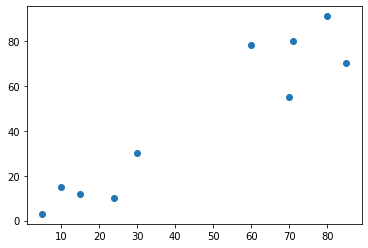

In [13]:
# https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
X = np.array([[5,3], [10,15], [15,12], [24,10], [30,30], [85,70], [71,80], [60,78], [70,55], [80,91],])
plt.scatter(X[:,0],X[:,1])

In [36]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

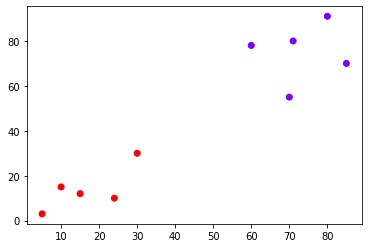

In [37]:
plt.scatter(X[:,0],X[:,1], c=cluster.labels_, cmap='rainbow')

Ok. Funciona.

## Dados do portfólio

Para usar nos dados do portfólio, temos que passar as strings para valor numérico.

In [32]:
# portfolio 1, reduzido (micro): p1micro
p1micro = p1.drop(columns=['Unnamed: 0', 'id'])

In [53]:
p1micro.dtypes == object

fl_matriz                                False
de_natureza_juridica                      True
sg_uf                                     True
natureza_juridica_macro                   True
de_ramo                                   True
setor                                     True
idade_empresa_anos                       False
idade_emp_cat                             True
fl_me                                    False
fl_sa                                    False
fl_epp                                   False
fl_mei                                   False
fl_ltda                                  False
dt_situacao                               True
fl_st_especial                           False
fl_email                                 False
fl_telefone                              False
fl_rm                                     True
nm_divisao                                True
nm_segmento                               True
fl_spa                                   False
fl_antt      

In [38]:
p1micro.head(3)

,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,...,qt_socios,qt_socios_pj,idade_media_socios,qt_socios_masculino,qt_socios_feminino,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
0,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,COMERCIO VAREJISTA,COMERCIO,0.646575,<= 1,False,False,...,1.0,0.0,45.0,1.0,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0
1,False,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,6.586301,5 a 10,False,False,...,NaN,NaN,NaN,NaN,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 360.000,01 A R$ 1.500.000,00",210000.0,1000915.2,4
2,True,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,8.010959,5 a 10,False,False,...,1.0,0.0,54.0,NaN,1.0,"ATE R$ 81.000,00","ATE R$ 81.000,00",50000.0,50000.0,0


In [75]:
# Vou começar com 4 features: de_natureza_juridica, sg_uf, de_ramo, de_nivel_atividade
categorical_cols = ['de_natureza_juridica', 'sg_uf', 'de_ramo', 'de_nivel_atividade']
for feat in categorical_cols:
    print(p1micro[feat].value_counts())
    print('\n')

EMPRESARIO INDIVIDUAL                                                     432
SOCIEDADE EMPRESARIA LIMITADA                                             105
EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITADA DE NATUREZA EMPRESARIA     15
SOCIEDADE ANONIMA FECHADA                                                   1
SOCIEDADE EMPRESARIA EM NOME COLETIVO                                       1
SOCIEDADE EM CONTA DE PARTICIPACAO                                          1
Name: de_natureza_juridica, dtype: int64


MA    157
RN    116
PI    103
AM     94
RO     64
AC     21
Name: sg_uf, dtype: int64


COMERCIO VAREJISTA    496
BENS DE CONSUMO        59
Name: de_ramo, dtype: int64


MEDIA          280
ALTA           153
BAIXA          116
MUITO BAIXA      2
Name: de_nivel_atividade, dtype: int64




In [57]:
# Usando LabelEncoder
#https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/
from sklearn import preprocessing
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()

In [99]:
# apply le on categorical feature columns
# https://towardsdatascience.com/encoding-categorical-features-21a2651a065c

#portfolio 1 com labelencoder: p1enc
p1enc=pd.DataFrame()
categorical_cols = ['de_natureza_juridica', 'sg_uf', 'de_ramo']
# %*%*%*%%*%*%*%%*%*%*%%*%*%*%%*%*%*%%*%*%*%
# IMPORTANTE aqui, só três features, para poder visualizar em um gráfico 3D.
# Também porque de_nivel_atividade tem alguns NaN, que tem que ser resolvidos depois
# %*%*%*%%*%*%*%%*%*%*%%*%*%*%%*%*%*%%*%*%*%
p1enc[categorical_cols] = p1micro[categorical_cols].apply(lambda col: le.fit_transform(col))

p1enc[categorical_cols].head(5)

,de_natureza_juridica,sg_uf,de_ramo
0,1,3,1
1,1,2,1
2,1,2,1
3,1,4,1
4,5,4,1


In [100]:
p1enc.shape

(555, 3)

In [101]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
p1enc['cluster'] = cluster.fit_predict(p1enc)

In [104]:
# aqui, estou somando um valor aleatório para fins de visualização.
# Se não for feito, um grupo grande de pontos fica condensado em um único ponto no gráfico
# e perde-se a noção de cluster
p1enc['de_natureza_juridica']=p1enc['de_natureza_juridica'] + ((np.random.rand(555)-0.5) *0.5)
p1enc['de_ramo']=p1enc['de_ramo'] + ((np.random.rand(555)-0.5) *0.5)
p1enc['sg_uf']=p1enc['sg_uf'] + ((np.random.rand(555)-0.5) *0.5)
p1enc.head(5)

,de_natureza_juridica,sg_uf,de_ramo,cluster
0,0.984601,2.605556,0.814230,0
1,0.857502,2.122750,1.088460,0
2,0.865770,1.907165,1.398208,0
3,0.616661,3.887108,1.075638,2
4,4.771306,3.993512,0.768496,1


In [103]:
import plotly.express as px
fig = px.scatter_3d(p1enc, x='de_natureza_juridica', y='sg_uf', z='de_ramo', color = 'cluster')
fig.show()

## Conclusão até o momento

Clusterização parece interessante. Observar que, das três categorias avaliadas, o `de_ramo` não teve muita influência, porque está bem polarizado em uma das classes. Próximos passos: incluir mais features (sabendo que vai impedir a visualização em mais de 3 dimensões) e aplicar redução de dimensionalidade (PCA? antes ou depois da clusterização?).